In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.0 MB/s 
     |████████████████████████████████| 6.6 MB 51.9 MB/s 
     |████████████████████████████████| 596 kB 56.7 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from transformers import pipeline
from sklearn.metrics import roc_auc_score, f1_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2022-08-12 08:32:49--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  6.97MB/s    in 0.5s    

2022-08-12 08:32:50 (6.97 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [6]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [7]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [8]:
# Output is a dictionary
classifier("This is such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

In [9]:
classifier("This show was not interesting")

[{'label': 'NEGATIVE', 'score': 0.9997871518135071}]

In [10]:
import torch

torch.cuda.is_available()

True

In [11]:
torch.cuda.current_device()

0

In [12]:
classifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [13]:
df = pd.read_csv('AirlineTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [14]:
df_ = df[['airline_sentiment', 'text']].copy()

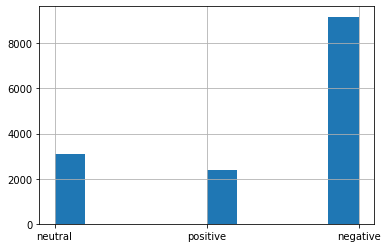

In [15]:
df_['airline_sentiment'].hist()

In [16]:
df_ = df_[df_.airline_sentiment != 'neutral'].copy()

In [17]:
target_map = {'positive':1, 'negative':0}
df_['target'] = df_['airline_sentiment'].map(target_map)

In [31]:
df_.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [19]:
len(df_)

11541

In [20]:
texts = df_['text'].tolist()
predictions = classifier(texts)

In [ ]:
predictions

In [ ]:
probs = [d['score'] if d['label'].startswith('P') else 1 - d['score']  
         for d in predictions]
probs

In [27]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]
preds = np.array(preds)

In [32]:
print("acc:", np.mean(df_['target'] == preds))

acc: 0.8898708950697514


In [33]:
cm = confusion_matrix(df_['target'], preds, normalize= "true")
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

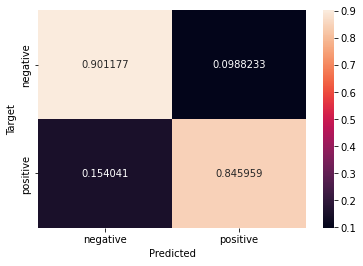

In [34]:
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [35]:
f1_score(df_['target'], preds)

0.7587777566900741

In [36]:
f1_score(1 - df_['target'], 1 - preds)

0.928647616908999

In [37]:
roc_auc_score(df_['target'], probs)

0.9485934229556097

In [38]:
roc_auc_score(1 - df_['target'], 1 - np.array(probs))

0.9485934229556096